In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image
import pickle
import emcee
import numpy as np
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12
C =cosmology.Planck15

In [2]:
def alpha(a_s,M_star,m):
    alpha = (1+a_s) - m/M_star
    return alpha
def sSFR(t):
    sSFR = 2.5*(t/3.5)**(-2.2)
    return sSFR
def rate_matrix(rates,m,t):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    #m is a vector - m[0] = m1, m[3] = m4
    rate_mtrx = pd.DataFrame(index=np.linspace(1,12,12),columns=np.linspace(1,12,12),data=np.zeros((12,12)))
    a_s = -1.4 
    M_star = 10.82

    for i in range(1,5): #things multiplied by BDN
        rate_mtrx[i][i] = -rates['from BD{}'.format(i)]['to RD{}'.format(i)] - rates['from BD{}'.format(i)]['to RE{}'.format(i+1)] - alpha(a_s,M_star,m[i-1])*sSFR(t)
    for i in range(1,5):
        rate_mtrx[i][i+4] = rates['from BD{}'.format(i)]['to RD{}'.format(i)]
        rate_mtrx[i+4][i+4] = -rates['from RD{}'.format(i)]['to RE{}'.format(i+1)]
    
    for i in range(1,5):
        rate_mtrx[i+8][i+8] = rates['from K']['to RE{}'.format(i)]
    for i in range(1,4):
        rate_mtrx[i][i+9] = rates['from BD{}'.format(i)]['to RE{}'.format(i+1)] # BD_N -> RE(n+1)
        rate_mtrx[i+4][i+9] = rates['from RD{}'.format(i)]['to RE{}'.format(i+1)] #RD_N -> RE_n+1
    return rate_mtrx
def modelrates(N, t, rates, rate_matrix_fn, m):
    rate_mtrx = rate_matrix_fn(rates,m,t)
    return np.dot(rate_mtrx, N)
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def find_nearest_idx(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
def plot_NF(F_RD,F_DR):
    colors = ['#008744','#0c457d','#aa1841','#54235c']
    fig, (axrd, axdr) = plt.subplots(1, 2, figsize=(12, 6))
    F_RD.plot(ax=axrd,colors=colors,lw=2)
    axrd.set(xlabel='$z$', ylabel='$f_{R|D}(z)$', ylim=(0, .4));
    F_DR.plot(ax=axdr,colors=colors,lw=2)
    axdr.set(xlabel='$z$')
    axdr.set(ylabel='$f_{D|R}(z)$', ylim=(0, 0.4));
    plt.tight_layout()

In [3]:
#define states for matrix of rates
statesto = pd.Index(('BD1', 'RD1', 'RE1'))
statesfrom = pd.Index(('BD1', 'RD1'))
for i in range(2,6):
    statesto=statesto.append(pd.Index(('BD%s'%i,'RD%s'%i,'RE%s'%i)))
for i in range(2,4):
    statesfrom=statesfrom.append(pd.Index(('BD%s'%i,'RD%s'%i)))
statesfrom = statesfrom.append(pd.Index(('BD4','RD4','K')))

In [29]:
#load dictionary of data; N_RD, N_BD, N_RE, f_RID, f_DIR evolutions for each mass bin
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [228]:
#centers of bins where f_rid and f_dir are evaluated in the data
z_centers = results['z_centers']
#mass bins
m_centers = results['m_centers']

#define times/redshifts to compute evolution in model
zstart = 1.0
zend = 0.3
z = np.linspace(zstart, zend, 100)
t = C.age(z)
t0 = C.age(zend).value

model_z = [find_nearest(z,i) for i in z_centers[:]] #closest redshift in model to observed redshift values, excluding z=1 
#(z=1 is the input value, will always match model!)
model_z = model_z * 8 #2 for each fraction, 4 for each mass = 16 series 


rate_vector_labels = pd.Index((('BD1 to RD1'),('BD2 to RD2'),('BD3 to RD3'), ('BD4 to RD4'),
                            ('BD1 to RE2'), ('BD2 to RE3'), ('BD3 to RE4'), ('BD4 to RE5'),
                              ('RD1 to RE2'), ('RD2 to RE3'), ('RD3 to RE4'), ('RD4 to RE5'),
                              ('K to RE1'), ('K to RE2'), ('K to RE3'), ('K to RE4')))

In [246]:
len(model)

40

In [238]:
len(yerr)

32

In [230]:
def lnlike(theta, x, y, yerr):
    bd_1_rd_1, bd_1_re_2, rd_1_re_2, k_re_1, \
    bd_2_rd_2, bd_2_re_3, rd_2_re_3, k_re_2, \
    bd_3_rd_3, bd_3_re_4, rd_3_re_4, k_re_3, \
    bd_4_rd_4, bd_4_re_5, rd_4_re_5, k_re_4 = theta #rate parameters 
    
    rate_vector=pd.Series(index=rate_vector_labels,data=[bd_1_rd_1, bd_1_re_2, rd_1_re_2, k_re_1,
    bd_2_rd_2, bd_2_re_3, rd_2_re_3, k_re_2,
    bd_3_rd_3, bd_3_re_4, rd_3_re_4, k_re_3,
    bd_4_rd_4, bd_4_re_5, rd_4_re_5, k_re_4,])

    
    rates = pd.DataFrame(index='to ' + statesto, columns='from ' + statesfrom,data=np.zeros(shape=(15,9)))
    for i in range(1,5):
        rates['from BD{}'.format(i)]['to RD{}'.format(i)]=rate_vector['BD{} to RD{}'.format(i,i)]
        rates['from BD{}'.format(i)]['to RE{}'.format(i+1)]=rate_vector['BD{} to RE{}'.format(i,i+1)]
        rates['from K']['to RE{}'.format(i)]=rate_vector['K to RE{}'.format(i)]
        rates['from RD{}'.format(i)]['to RE{}'.format(i+1)]=rate_vector['RD{} to RE{}'.format(i,i+1)]

    #set initial values
    states = pd.Index((('BD1'),('BD2'),('BD3'),('BD4'),('RD1'),('RD2'),('RD3'),('RD4'),('RE1'),('RE2'),('RE3'),('RE4')))
    #inital BD, RD, RE for masses 1-4 (z=1)
    N0=pd.Series(index=states)
    for i, m in enumerate(m_centers):
        N0['BD{}'.format(i+1)] = results['M={}'.format(m)]['N_BD'][len(z_centers)-1] #z=1 values
        N0['RD{}'.format(i+1)] = results['M={}'.format(m)]['N_RD'][len(z_centers)-1]
        N0['RE{}'.format(i+1)] = results['M={}'.format(m)]['N_RE'][len(z_centers)-1]    
    N0 /= N0.sum()  # normalise to unity
        
    #evolve numbers from z=1 to z=0.3
    N = odeint(modelrates, N0, t, args=(rates, rate_matrix, m_centers))
    N = pd.DataFrame(index=z, columns=states, data=N)
    N=N[::-1] #number evolution of BD,RD,RE
    
    F_RD = pd.DataFrame(index=N.index) #evolution of fractions
    F_DR = pd.DataFrame(index=N.index) #evolution of fractions

    for i in range(1,5):
        F_RD['$f_{R|D}\_%s$'%i] = N['RD{}'.format(i)] / (N['RD{}'.format(i)]+N['BD{}'.format(i)])
    for i in range(1,5):
        F_DR['$f_{D|R}\_%s$'%i] = N['RD{}'.format(i)] / (N['RD{}'.format(i)]+N['RE{}'.format(i)])

    model = []
    for m,M in enumerate(m_centers):
        for zc in model_z[0:len(z_centers[:])]:
            model.append(F_RD['$f_{R|D}\_%s$'%(m+1)][zc])
        for zc in model_z[0:len(z_centers[:])]:
            model.append(F_DR['$f_{D|R}\_%s$'%(m+1)][zc])
    model = np.array(model)
        
    inv_sigma2 = 1.0/(yerr**2 + model**2) #*np.exp(2*lnf))
    answer = -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    if np.isnan(answer):
        answer=-np.inf
    return answer


In [231]:
#prior -restrictions on m 
def lnprior(theta):
    bd_1_rd_1, bd_1_re_2, rd_1_re_2, k_re_1, \
    bd_2_rd_2, bd_2_re_3, rd_2_re_3, k_re_2, \
    bd_3_rd_3, bd_3_re_4, rd_3_re_4, k_re_3, \
    bd_4_rd_4, bd_4_re_5, rd_4_re_5, k_re_4 = theta #rate parameters 
    mn = .01
    mx = .5
    kmn = -1*mx #net elliptical merger rate can be negative
    #Tracer()()
    if mn < bd_1_rd_1 < mx and mn < bd_1_re_2 < mx and mn < rd_1_re_2 < mx and kmn < k_re_1 < mx and \
      mn < bd_2_rd_2 < mx and mn < bd_2_re_3 < mx and mn < rd_2_re_3 < mx and kmn < k_re_2 < mx and \
        mn < bd_3_rd_3 < mx and mn < bd_3_re_4 < mx and mn < rd_3_re_4 < mx and kmn < k_re_3 < mx and \
        mn < bd_4_rd_4 < mx and mn < bd_4_re_5 < mx and mn < rd_4_re_5 < mx and kmn < k_re_4 < mx:
        return 0.0
    #Tracer()()
    return -np.inf
#check that parameters fit within lnprior bounds; if not, return np.inf, if is, return lnlike(theta,x,y,yerr) (why +lp???)

def lnprob(theta, x, y, yerr):
    #Tracer()()
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    answer = lp + lnlike(theta, x, y, yerr)
    #return lp + lnlike(theta, x, y, yerr)
    return answer

In [247]:
#"real" data
n_zs = len(z_centers[:])#number of data points

x=np.array(z_centers[:]*8) #observed redshifts X 2 
y = [] 
yerr = []
for mass in m_centers:
    for i in range(0,n_zs):
        y.append(results['M=%s'%mass]['f_RID'][i])
        yerr.append(results['M=%s'%mass]['f_RID_err'][i])
    for i in range(0,n_zs):
        y.append(results['M=%s'%mass]['f_DIR'][i])
        yerr.append(results['M=%s'%mass]['f_DIR_err'][i])

y = np.array(y)
yerr = np.array(yerr)


In [248]:
ndim, nwalkers = 16, 100
pos = [[.25]*ndim + .1*np.random.randn(ndim) for i in range(nwalkers)] #choosing starting locations at random guess .2 for each rate
for rateset in pos:
    rateset[0]=.1+.1*np.random.randn() #bd_1_rd_1 seems to hover around .1 in last test 
    for i in range(7,16,4): #K_RE1 can be + or - 
        rateset[i] = np.random.randint(-500,500)*.001 #K_RE1 can be + or - 3, 7, 11, 15

In [249]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr),a=0.02)


In [250]:
sampler.run_mcmc(pos, 500);


(-0.5, 0.5)

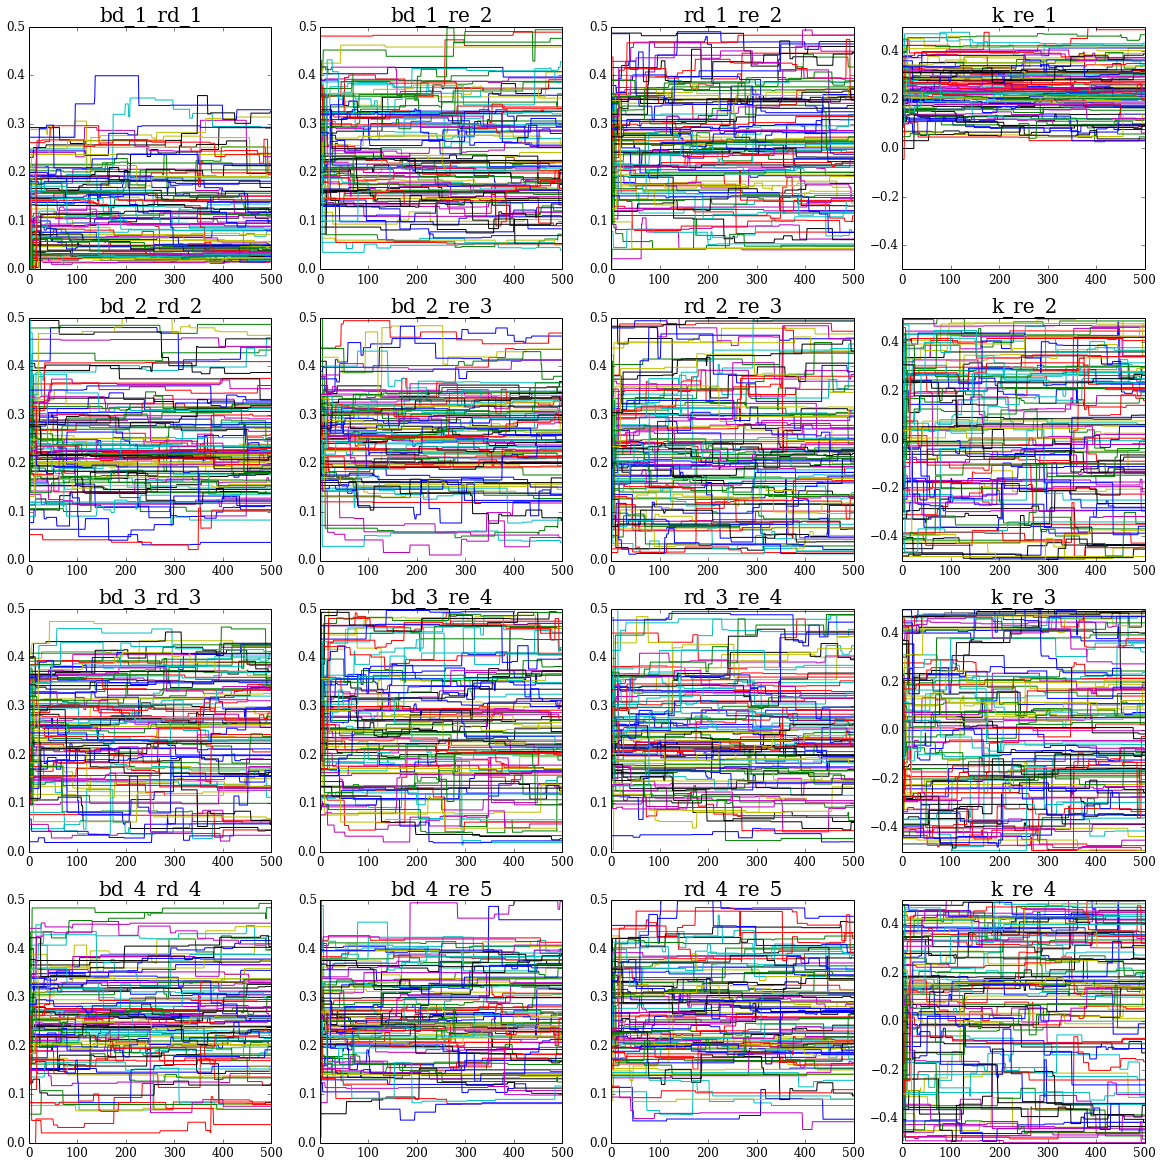

In [251]:
import matplotlib.gridspec as gridspec

xp=np.linspace(1,500,500)

f=plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(4,4)
#mass 1 
ax=plt.subplot(gs[0,0])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,0])
plt.title('bd_1_rd_1',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[0,1])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,1])
plt.title('bd_1_re_2',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[0,2])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,2])
plt.title('rd_1_re_2',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[0,3])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,3])
plt.title('k_re_1',fontsize=20)
plt.ylim(-.5,.5)

#mass2
ax=plt.subplot(gs[1,0])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,4])
plt.title('bd_2_rd_2',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[1,1])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,5])
plt.title('bd_2_re_3',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[1,2])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,6])
plt.title('rd_2_re_3',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[1,3])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,7])
plt.title('k_re_2',fontsize=20)
plt.ylim(-.5,.5)

#mass3
ax=plt.subplot(gs[2,0])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,8])
plt.title('bd_3_rd_3',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[2,1])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,9])
plt.title('bd_3_re_4',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[2,2])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,10])
plt.title('rd_3_re_4',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[2,3])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,11])
plt.title('k_re_3',fontsize=20)
plt.ylim(-.5,.5)

#mass 4
ax=plt.subplot(gs[3,0])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,12])
plt.title('bd_4_rd_4',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[3,1])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,13])
plt.title('bd_4_re_5',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[3,2])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,14])
plt.title('rd_4_re_5',fontsize=20)
plt.ylim(0,.5)
ax=plt.subplot(gs[3,3])
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,15])
plt.title('k_re_4',fontsize=20)
plt.ylim(-.5,.5)


In [254]:
samples = sampler.chain[:,:, :].reshape((-1, ndim))

/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


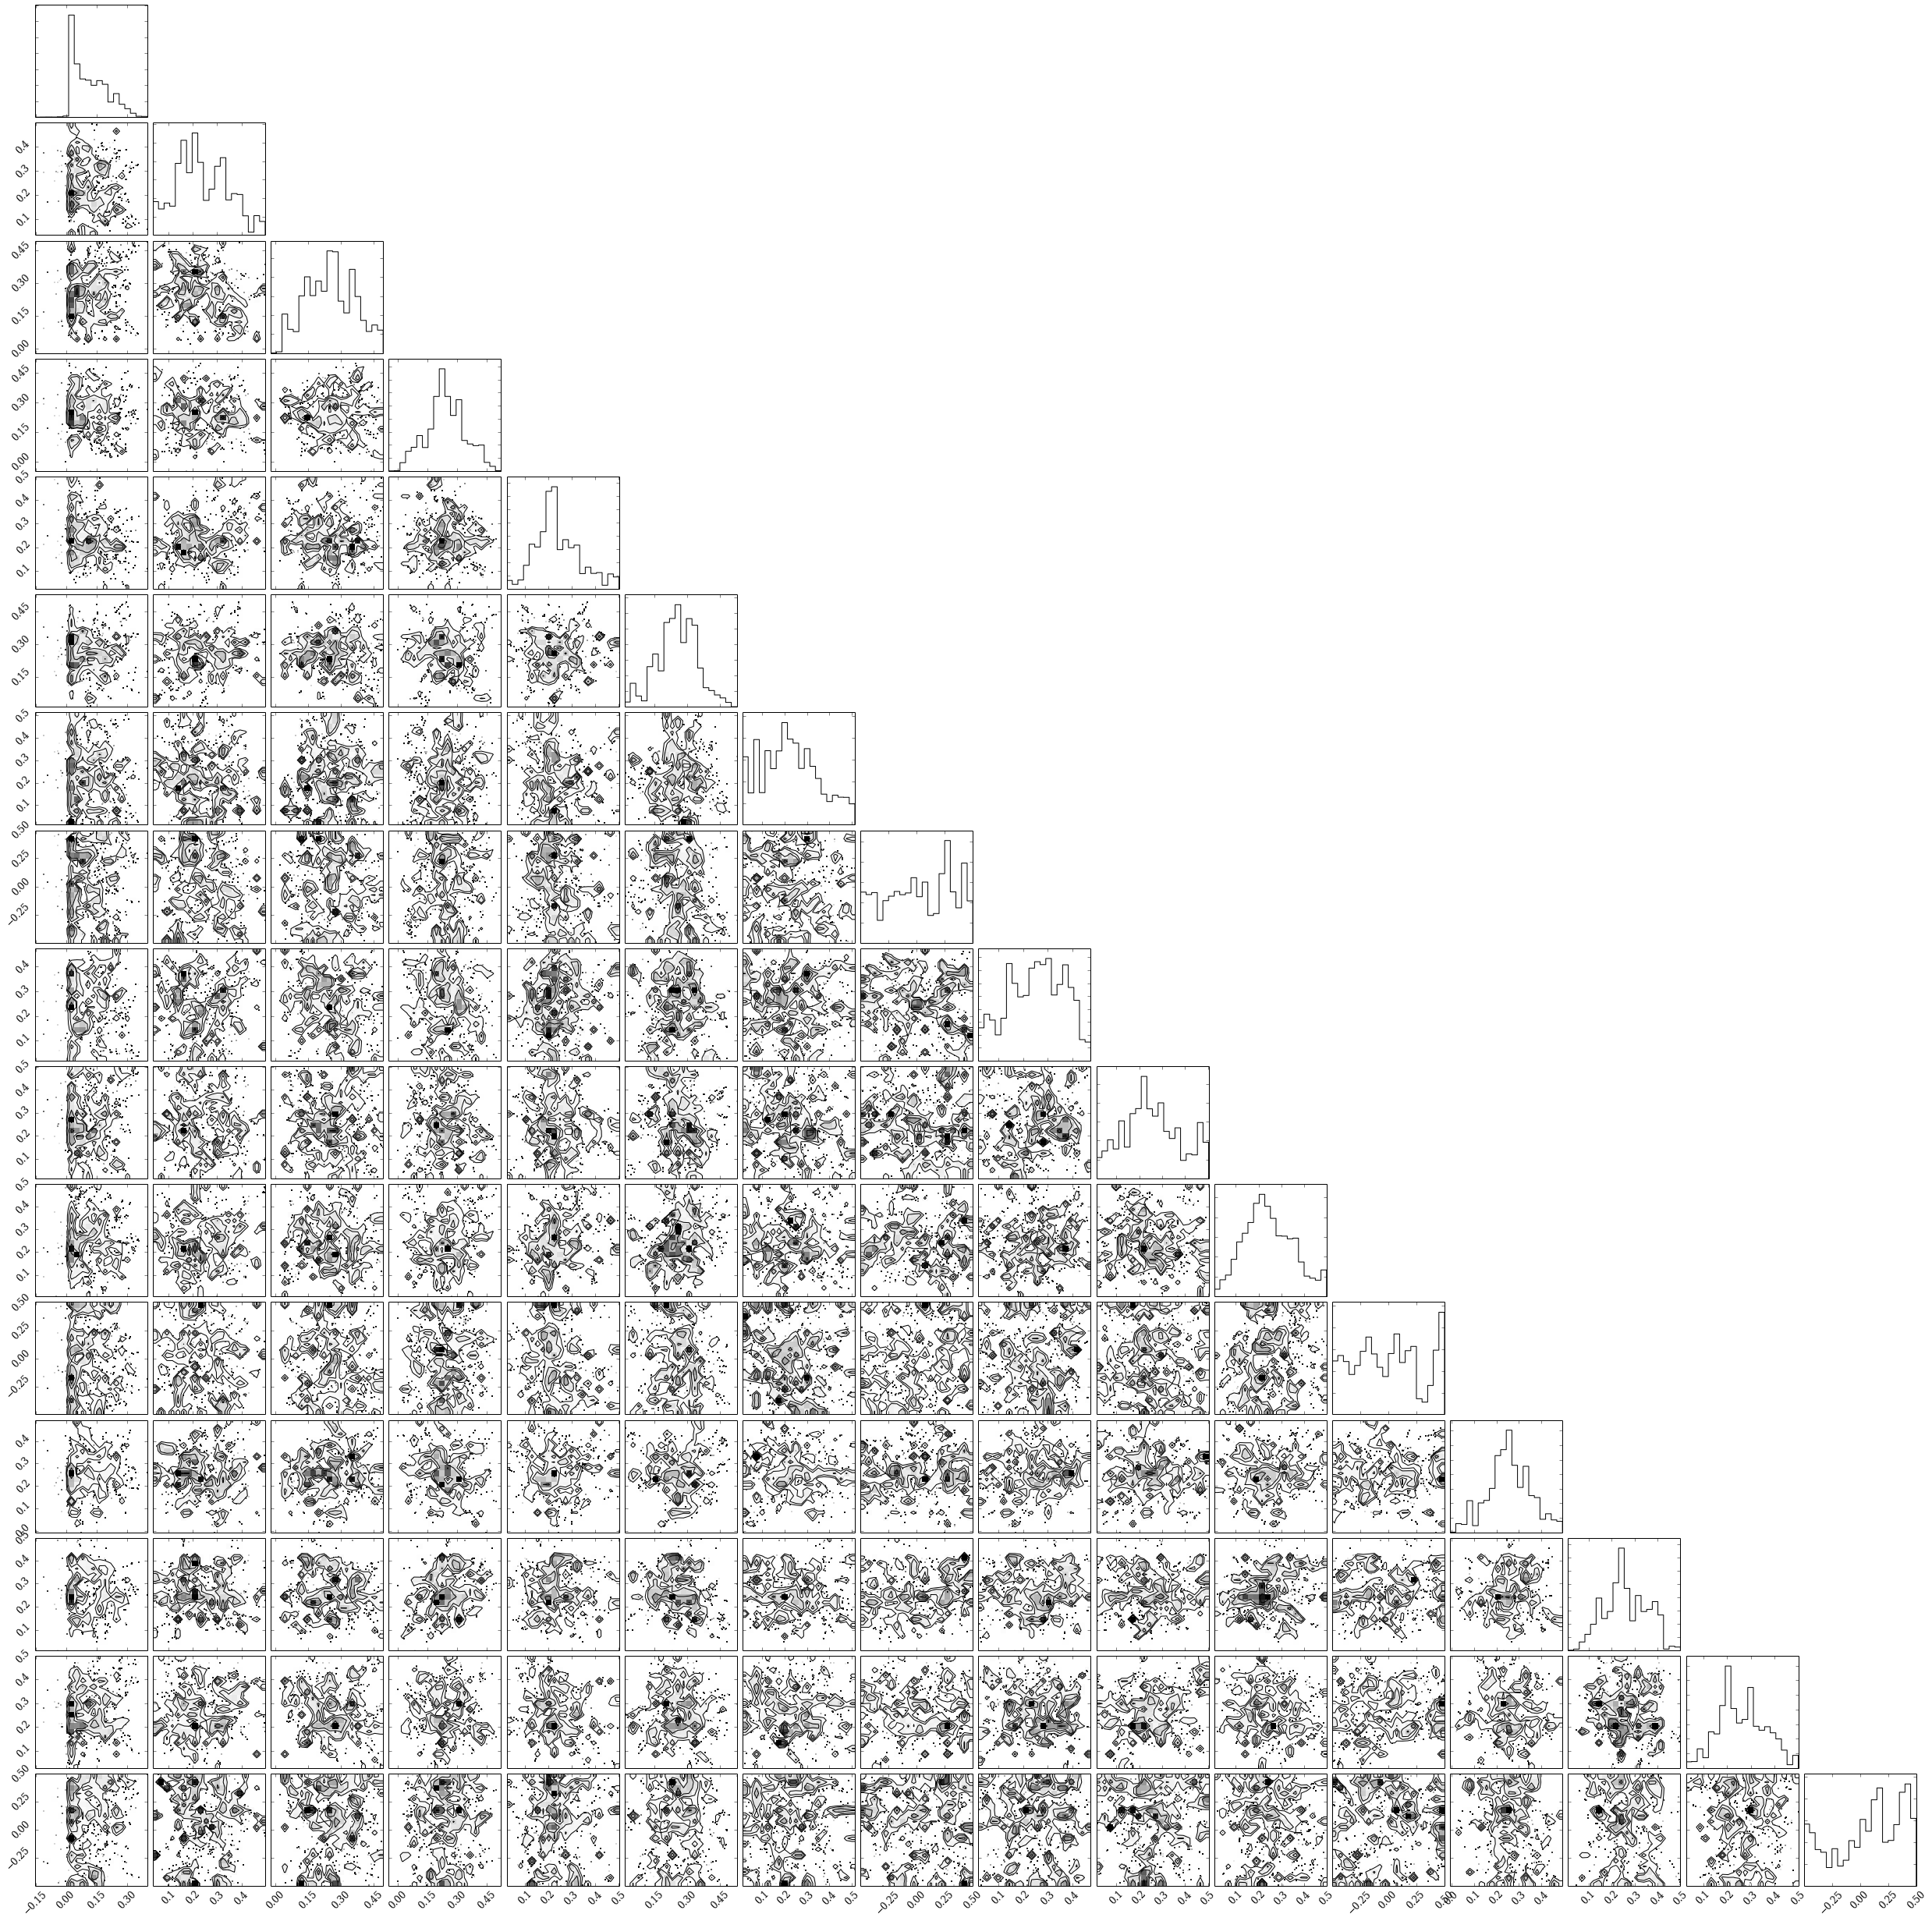

In [255]:
import corner
fig = corner.corner(samples)


In [144]:
for i in range(0,nwalkers):
    plt.plot(xp,sampler.chain[i,:,16])


IndexError: index 16 is out of bounds for axis 2 with size 16

In [ ]:
len(sampler.chain[0,:,0])

In [9]:
x

array([ 0.31,  0.54,  0.76,  0.31,  0.54,  0.76,  0.31,  0.54,  0.76,
        0.31,  0.54,  0.76,  0.31,  0.54,  0.76,  0.31,  0.54,  0.76,
        0.31,  0.54,  0.76,  0.31,  0.54,  0.76])

In [126]:
np.exp(0)

1.0

In [ ]:
    y = []
    for mass in m_centers:
        for i in range(0,3):
            y.append(results['M=%s'%mass]['f_RID'][i])
        for i in range(0,3):
            y.append(results['M=%s'%mass]['f_DIR'][i])
    y = np.array(y)


In [ ]:
y

In [ ]:
    model = []
    for m,M in enumerate(m_centers):
        for zc in model_z[0:3]:
            model.append(F_RD['$f_{R|D}\_%s$'%(m+1)][zc])
        for zc in model_z[0:3]:
            model.append(F_DR['$f_{D|R}\_%s$'%(m+1)][zc])
    model = np.array(model)


In [ ]:
len(model)

In [ ]:
len(y)

In [ ]:
10**8

In [ ]:
for mass in m_centers:
    for i in range(0,3):
        print mass,i

In [178]:
r = [position[10] for position in pos]

(array([  2.,   0.,  10.,  14.,  12.,  17.,  19.,  14.,  10.,   2.]),
 array([-0.07493249, -0.02321944,  0.02849362,  0.08020667,  0.13191973,
         0.18363278,  0.23534584,  0.28705889,  0.33877195,  0.390485  ,
         0.44219806]),
 <a list of 10 Patch objects>)

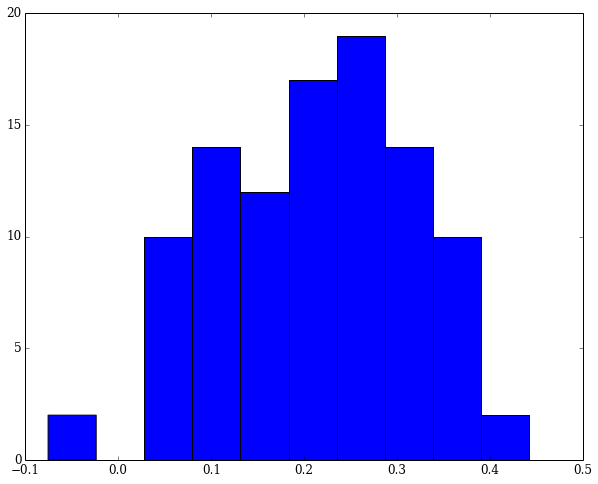

In [179]:
plt.hist(r)